Source of inspiration for this model: https://www.kaggle.com/code/imsparsh/gtzan-genre-classification-deep-learning-val-92-4/notebook

In [87]:
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib as plt
import librosa
import os
import subprocess
import csv
from sklearn import metrics, model_selection, preprocessing

Define paths for this model

In [88]:
absolute_path = "f:\\AI Projects\\Music Classification"
relative_path = "Data\\GTZAN\\genres"
full_path = os.path.join(absolute_path, relative_path)
print(full_path)

f:\AI Projects\Music Classification\Data\GTZAN\genres


List all music genres contained in this dataset

In [89]:
generes_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

In [90]:
len(generes_list)

10

In [104]:
def generate_metadata(file_name = "metadata.csv"):
    file_path = os.path.join(full_path,file_name)
    force_reload = True
    
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate tempo'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    if not os.path.exists(file_path):
        file = open(file_name, 'w', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(header)
        for g in generes_list:
            for filename in os.listdir(f'{full_path}\\{g}'):
                songname = f'{full_path}\\{g}\\{filename}'
                y, sr = librosa.load(songname, mono=True, duration=30)
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rmse = librosa.feature.rmse(y=y)
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(y)
                tempo = librosa.beat.tempo(y)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
                for e in mfcc:
                    to_append += f' {np.mean(e)}'
                to_append += f' {g}'
                file = open(file_name, 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())
    else:
        print("Skipping metadata generation")
    return pd.read_csv(file_path)

Read in the metadata

In [91]:
metadata = generate_metadata()
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Use all 100 samples for training data

Hand picked songs for test data
E.g Livin on a prayer
Don't stop believin
Master of puppets
Smells like teens spirit
As it was
All too well
Beethoven symphony 9


In [92]:
print(list(metadata.columns[metadata.isnull().any()]))

[]


No NA or null values in the metadata

Add labels to each file 

In [93]:
label_index = dict()
index_label = dict()

for i, x in enumerate(metadata.label.unique()):
    label_index[x] = i
    index_label[i] = x

metadata.label = [label_index[l] for l in metadata.label]
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,0


Shuffle the dataset

In [94]:
seed = 12
np.random.seed(seed)
df_shuffle = metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.drop(['filename','length'],axis=1,inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [95]:
X_train, df_test_valid_X, y_train, df_test_valid_y = model_selection.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)

X_dev, X_test, y_dev, y_test = model_selection.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

Scale the features

In [96]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [97]:
dropout_rate = 0.2

model = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1024)              59392     
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_49 (Dense)            (None, 512)               524800    
                                                                 
 dropout_41 (Dropout)        (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               131328    
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 128)              

In [98]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [99]:
history = model.fit(X_train,y_train,validation_data=(X_dev,y_dev),epochs=500,batch_size=128)

Epoch 1/500
6/6 [==============================] - 1s 45ms/step - loss: 2.1211 - accuracy: 0.2300 - val_loss: 1.9436 - val_accuracy: 0.3384
Epoch 2/500
6/6 [==============================] - 0s 15ms/step - loss: 1.7483 - accuracy: 0.3771 - val_loss: 1.4259 - val_accuracy: 0.4848
Epoch 3/500
6/6 [==============================] - 0s 18ms/step - loss: 1.4783 - accuracy: 0.4786 - val_loss: 1.3092 - val_accuracy: 0.5253
Epoch 4/500
6/6 [==============================] - 0s 16ms/step - loss: 1.3329 - accuracy: 0.5457 - val_loss: 1.0935 - val_accuracy: 0.6768
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 1.1334 - accuracy: 0.6029 - val_loss: 1.0620 - val_accuracy: 0.6465
Epoch 6/500
6/6 [==============================] - 0s 12ms/step - loss: 1.0657 - accuracy: 0.6486 - val_loss: 1.2004 - val_accuracy: 0.6061
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 1.0040 - accuracy: 0.6500 - val_loss: 0.9928 - val_accuracy: 0.6616
Epoch 8/500
6/6 [===

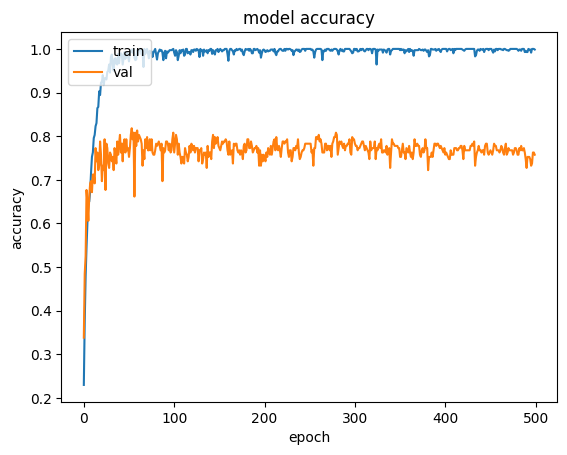

In [100]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

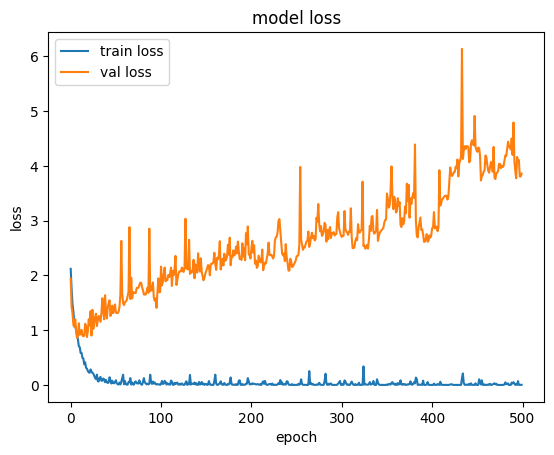

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','val loss'], loc='upper left')
plt.show()

In [102]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=128)

print(f"Loss: {round(loss,4)}")
print(f"Accuracy: {round(accuracy * 100,2)}%")

1/1 [==============================] - 0s 27ms/step - loss: 3.4019 - accuracy: 0.7255
Loss: 3.4019
Accuracy: 72.55%


Accuracy currently sitting at 73.5%